In [1]:
%%capture
!pip install numpy matplotlib

# Collision Model Assumption

The base station cannot decode any signal if both devices transmit at the same time (i.e., both emissions are nonzero).
This is a simulates a wireless constraint for many IoT setups like LoRa, NB-IoT, or Wi-Fi without advanced collision handling.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Device 1: Poisson HMM
class PoissonHMM:
    def __init__(self, A, lambdas, pi):
        self.A = A
        self.lambdas = lambdas
        self.pi = pi
        self.n_states = len(pi)

    def sample(self, T):
        states = np.zeros(T, dtype=int)
        emissions = np.zeros(T, dtype=int)

        states[0] = np.random.choice(self.n_states, p=self.pi)
        emissions[0] = np.random.poisson(self.lambdas[states[0]])

        for t in range(1, T):
            states[t] = np.random.choice(self.n_states, p=self.A[states[t - 1]])
            emissions[t] = np.random.poisson(self.lambdas[states[t]])

        return states, emissions

In [4]:
# Device 2: Discrete HMM
class DiscreteHMM:
    def __init__(self, A, B, pi):
        self.A = A
        self.B = B
        self.pi = pi
        self.n_states = A.shape[0]
        self.n_obs = B.shape[1]

    def sample(self, T):
        states = np.zeros(T, dtype=int)
        emissions = np.zeros(T, dtype=int)

        states[0] = np.random.choice(self.n_states, p=self.pi)
        emissions[0] = np.random.choice(self.n_obs, p=self.B[states[0]])

        for t in range(1, T):
            states[t] = np.random.choice(self.n_states, p=self.A[states[t - 1]])
            emissions[t] = np.random.choice(self.n_obs, p=self.B[states[t]])

        return states, emissions


## Collision logic

We define the observed value at the base station (combined_obs[t]) as:
- 0 if both devices are silent.
- The emission of the active device if only one is transmitting.
- -1 (or another marker like None) if both transmit at the same time → collision.

In [5]:
def apply_collision_model(o1, o2):
    result = []
    for a, b in zip(o1, o2):
        if a == 0 and b == 0:
            result.append(0)
        elif a > 0 and b == 0:
            result.append(a)
        elif a == 0 and b > 0:
            result.append(b)
        else:
            result.append(-1)  # Collision
    return np.array(result)

## Simulation

In [6]:
T = 50
A1 = np.array([[0.85, 0.15], [0.3, 0.7]])
lambda1 = [0.2, 2.0]
pi1 = [1.0, 0.0]
device1 = PoissonHMM(A1, lambda1, pi1)

A2 = np.array([[0.9, 0.1], [0.4, 0.6]])
B2 = np.array([[0.95, 0.05, 0.0], [0.1, 0.5, 0.4]])
pi2 = [1.0, 0.0]
device2 = DiscreteHMM(A2, B2, pi2)


In [7]:
# simulation
s1, o1 = device1.sample(T)
s2, o2 = device2.sample(T)

This models a realistic base station which only detects unambiguous transmissions.
You could use this to:

- Train a model to detect collision likelihood
- Estimate individual device states using partial observations
- Explore collision avoidance policies (TDMA, CSMA, etc.)

In [8]:
# collisions
combined_obs = apply_collision_model(o1, o2)

## print results

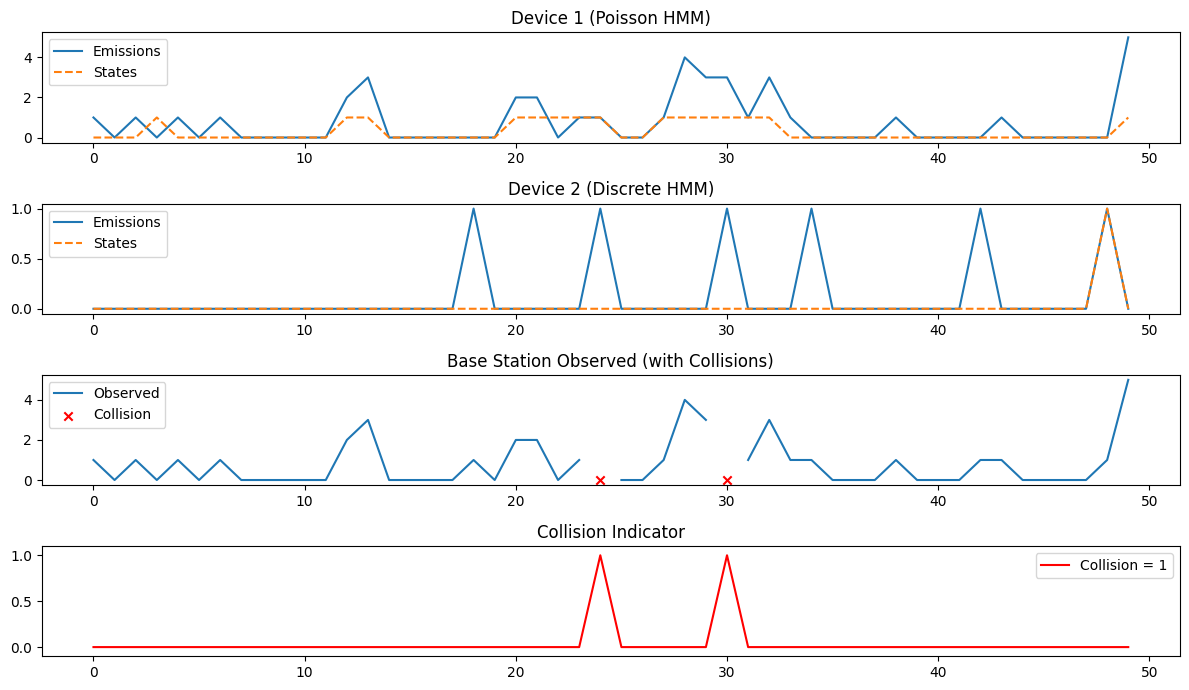

In [9]:
plt.figure(figsize=(12, 7))

plt.subplot(4, 1, 1)
plt.title("Device 1 (Poisson HMM)")
plt.plot(o1, label='Emissions')
plt.plot(s1, '--', label='States')
plt.legend()

plt.subplot(4, 1, 2)
plt.title("Device 2 (Discrete HMM)")
plt.plot(o2, label='Emissions')
plt.plot(s2, '--', label='States')
plt.legend()

plt.subplot(4, 1, 3)
plt.title("Base Station Observed (with Collisions)")
obs_display = np.where(combined_obs == -1, np.nan, combined_obs)  # Show collisions as gaps
plt.plot(obs_display, label='Observed')
plt.scatter(np.where(combined_obs == -1), [0]*np.sum(combined_obs == -1), color='red', marker='x', label='Collision')
plt.legend()

plt.subplot(4, 1, 4)
plt.title("Collision Indicator")
plt.plot((combined_obs == -1).astype(int), color='red', label='Collision = 1')
plt.ylim(-0.1, 1.1)
plt.legend()

plt.tight_layout()
plt.show()

Collision times are marked in red and shown as missing in the main plot.